In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as colors
from matplotlib.ticker import FuncFormatter

from itertools import combinations

from scipy.stats.qmc import LatinHypercube

from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor

In [2]:
%load_ext autoreload
%autoreload 2
from common import *
from metrics import *
from shifty_kernels import ProjectionKernel, ConstantKernel, RBF, WhiteKernel, SymmetricKernel1D

In [3]:
# Misc
import sys
sys.path.insert(0, '../misc')
from plots import *

In [4]:
plt.style.use('../misc/report.mplstyle')

# Toggle to save plots as pdf
save=True
save_dir = "../../../tex/03_gaussian_process_regression/img/"

## Analyzing the Dataset (Friedman Function)

In [5]:
dim = 5
sigma = .7
N = 1000
X = LatinHypercube(dim).random(N)
y = noisy_friedman(X, sigma=sigma)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)
y_train_mean = np.mean(y_train)
y_train = y_train - y_train_mean
y_test = y_test - y_train_mean

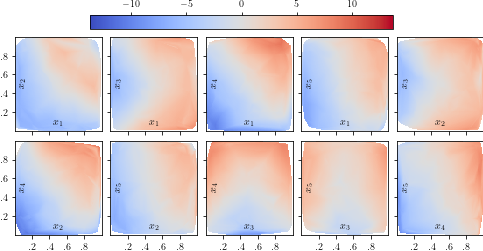

In [14]:
from scipy.interpolate import LinearNDInterpolator

def my_formatter(x, pos):
    val_str = '{:g}'.format(x)
    if np.abs(x) > 0 and np.abs(x) < 1:
        return val_str.replace("0", "", 1)
    else:
        return val_str
    
interp = LinearNDInterpolator(X_train, y_train)
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(8.4,3.7), sharex=True, sharey=True)
planes = list(combinations(np.arange(5),2))
ax = ax.flatten()
    
M = 100
dim = 5
x = y = np.linspace(0,1,M)
xx, yy = np.meshgrid(x,y)
fmax = np.max(y_train)
fmin = np.min(y_train)
halfrange=max(np.abs(fmin), np.abs(fmax))

major_formatter = FuncFormatter(my_formatter)
x_cross = 0.5
for i,plane_coordinates in enumerate(planes):
    x = np.linspace(np.min(X_train[:,plane_coordinates[0]]),np.max(X_train[:,plane_coordinates[0]]),M)
    y = np.linspace(np.min(X_train[:,plane_coordinates[1]]),np.max(X_train[:,plane_coordinates[1]]),M)
    xx, yy = np.meshgrid(x,y)
    X = x_cross * np.ones((M*M,dim))
    X[:,plane_coordinates[0]] = xx.flatten()
    X[:,plane_coordinates[1]] = yy.flatten()
    fxy = interp(X).reshape(M,M)
    
    ax[i].grid(False)
    im = ax[i].pcolormesh(xx,yy,fxy, cmap="coolwarm",
                      rasterized=True,
                      norm=colors.CenteredNorm(halfrange=halfrange))
    
    ax[i].set_xlabel(rf"$x_{plane_coordinates[0]+1}$", color="k")
    ax[i].set_ylabel(rf"$x_{plane_coordinates[1]+1}$", color="k")
    ax[i].set_xlim([0,1])
    ax[i].set_ylim([0,1])
    ax[i].xaxis.labelpad=-18
    ax[i].yaxis.labelpad=-15
    ax[i].xaxis.set_ticks(np.arange(0.2, 1, 0.2))
    ax[i].yaxis.set_ticks(np.arange(0.2, 1, 0.2))
    ax[i].xaxis.set_major_formatter(major_formatter)
    ax[i].yaxis.set_major_formatter(major_formatter)
    
for a in ax[5:10]:
    a.xaxis.labelpad=-30
    
for a in [ax[0], ax[5]]:
    a.yaxis.labelpad=-25
    
plt.subplots_adjust(top=.87, wspace=0.1, hspace=0.1)
cbar_ax = fig.add_axes([0.25, 0.9, 0.5, 0.05])
cbar_ax.grid(False)

fig.colorbar(im, cax=cbar_ax, orientation="horizontal")
cbar_ax.xaxis.set_label_position('top') 
cbar_ax.xaxis.tick_top()

if save:
    fig.savefig(save_dir + f"friedman_crosssections_x_{x_cross:.2f}.pdf",
                bbox_inches="tight",dpi=1000,pad_inches = 0.02)
else:
    plt.show()

## Kernel Comparison

In [7]:
# Generates trivial projection matrix in x_direction 
def P(dim, direction):
    P_x = np.zeros((dim,dim))
    P_x[direction,direction] = 1
    return P_x

sqexp = ConstantKernel(constant_value=1) * RBF(length_scale=[0.1])
coupling = ConstantKernel(constant_value=1) * ProjectionKernel(sqexp, P(dim, 0), tag="x0") * ProjectionKernel(sqexp, P(dim, 1), tag="x1")
kernels = {
    "sq_exp":sqexp,
    "sq_exp_ard":(ConstantKernel(constant_value=1) * RBF(length_scale=dim * [0.1])),
    "indep_sq_exp_12345":  ProjectionKernel(sqexp, P(dim, 0), tag="x1") \
                         + ProjectionKernel(sqexp, P(dim, 1), tag="x2") \
                         + ProjectionKernel(sqexp, P(dim, 2), tag="x3") \
                         + ProjectionKernel(sqexp, P(dim, 3), tag="x4") \
                         + ProjectionKernel(sqexp, P(dim, 4), tag="x5"),
    "coupling_12_indep_sq_exp_345":  coupling + ProjectionKernel(sqexp, P(dim, 2), tag="x3") \
                                              + ProjectionKernel(sqexp, P(dim, 3), tag="x4") \
                                              + ProjectionKernel(sqexp, P(dim, 4), tag="x5"),
    "coupling_12_symmetric_3_sq_exp_45":  coupling + SymmetricKernel1D(ProjectionKernel(sqexp, P(dim, 2), tag="x3"), offset=0.5) \
                                                   + ProjectionKernel(sqexp, P(dim, 3), tag="x4") \
                                                   + ProjectionKernel(sqexp, P(dim, 4), tag="x5")
}


In [12]:
import warnings
from sklearn.exceptions import ConvergenceWarning

class NoiseFittedGP(GaussianProcessRegressor):
    """
    Trivial GaussianProcessRegressor derivative that infers the noise of the data
    but predicts the latent function f instead of the noisy y. It is assumed that the kernel passed in has no
    WhiteKernel contribution for modelling iid gaussian noise. This will be added by NoiseFittedGP.
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.kernel = self.kernel + WhiteKernel(noise_level=0.1)
        self.alpha = 0
        
    def fit(self,X,y):
        super().fit(X,y)
        self.alpha = self.kernel_.k2.noise_level
        self.kernel_.k2.noise_level = 0
        return self

trained_gps = {}
hyperparameters = {
    "n_restarts_optimizer": 10
}
prediction_error={}
prediction_error_std={}

warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
for name, kernel in kernels.items():
    gp = NoiseFittedGP(kernel=kernel, **hyperparameters)
    print(f"Kernel of {name}: {gp.kernel}")
    prediction_error[name], prediction_error_std[name] = prediction_error_CV(squared_error, gp, X_train, y_train)

Kernel of sq_exp: 1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.1)
Kernel of sq_exp_ard: 1**2 * RBF(length_scale=[0.1, 0.1, 0.1, 0.1, 0.1]) + WhiteKernel(noise_level=0.1)
Kernel of indep_sq_exp_12345: ProjectionKernel(x1, 1**2 * RBF(length_scale=0.1)) + ProjectionKernel(x2, 1**2 * RBF(length_scale=0.1)) + ProjectionKernel(x3, 1**2 * RBF(length_scale=0.1)) + ProjectionKernel(x4, 1**2 * RBF(length_scale=0.1)) + ProjectionKernel(x5, 1**2 * RBF(length_scale=0.1)) + WhiteKernel(noise_level=0.1)
Kernel of coupling_12_indep_sq_exp_345: 1**2 * ProjectionKernel(x0, 1**2 * RBF(length_scale=0.1)) * ProjectionKernel(x1, 1**2 * RBF(length_scale=0.1)) + ProjectionKernel(x3, 1**2 * RBF(length_scale=0.1)) + ProjectionKernel(x4, 1**2 * RBF(length_scale=0.1)) + ProjectionKernel(x5, 1**2 * RBF(length_scale=0.1)) + WhiteKernel(noise_level=0.1)
Kernel of coupling_12_symmetric_3_sq_exp_45: 1**2 * ProjectionKernel(x0, 1**2 * RBF(length_scale=0.1)) * ProjectionKernel(x1, 1**2 * RBF(length_scale=0.1

{'sq_exp': 0.6327633833636794, 'sq_exp_ard': 2.8670489727061805, 'indep_sq_exp_12345': 2.4733190207249813, 'coupling_12_indep_sq_exp_345': 0.5218773868285642, 'coupling_12_symmetric_3_sq_exp_45': 0.49901000557838565}
{'sq_exp': 0.07630937134365721, 'sq_exp_ard': 2.404524801368707, 'indep_sq_exp_12345': 0.3164668976917431, 'coupling_12_indep_sq_exp_345': 0.05270984296996853, 'coupling_12_symmetric_3_sq_exp_45': 0.05598741865077425}


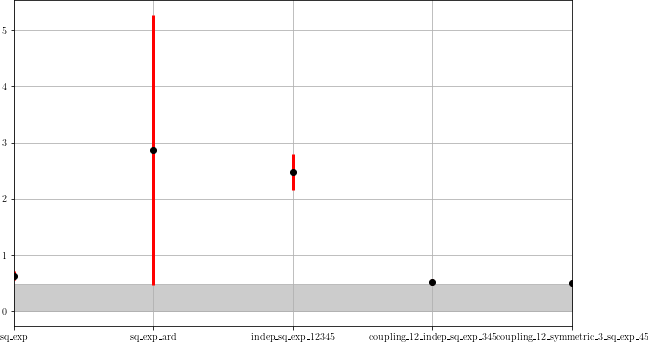

In [13]:
size = (10,6)
fig, ax = plt.subplots(figsize=size)

prediction_errors_kernel, prediction_errors = list(prediction_error.keys()), list(prediction_error.values())
prediction_errors_std = list(prediction_error_std.values())
print(prediction_error)
print(prediction_error_std)

ax.errorbar(prediction_errors_kernel, prediction_errors, yerr=prediction_errors_std, fmt='o', color='black',
             ecolor='red', elinewidth=3, capsize=0);
ax.fill_between(prediction_errors_kernel, 0, sigma**2, alpha=0.4, color="gray")
plt.show()

### ToDo in this Notebook
* Clean up MSE plot
* One plot of the nonconvex objective function (-log marginal likelihood)?
* Maybe show covariance matrix of trained GPs with rows permuted such that we minimize their distance (to see clusters of high correlation)?